# 数据预处理部分

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, sin, sqrt
import time


## 导入数据

In [7]:
#读取csv数据，使用chunksize参数实现分块读入
csv = pd.read_csv("20140803_train.csv", sep=',', names=['car_id', 'lat', 'lon', 'passenger', 'time'], chunksize=1000000, )
data=[]
for tmp in csv:
    #1.对每一个分块tmp处理
    tmp['time'] = pd.to_datetime(tmp['time'])
#     tmp["day"] = tmp['time'].apply(lambda x:x.day)
#     tmp["h"] = tmp['time'].apply(lambda x:x.hour)
#     tmp['m'] = tmp['time'].apply(lambda x:x.minute)
#     tmp['s'] = tmp['time'].apply(lambda x:x.second)
#     tmp.drop(['time'], axis=1, inplace=True)
    
    #2.添加每一个tmp
    data.append(tmp)

#连接每个分块，并保存
df = pd.concat(data, ignore_index=True)

# df.to_csv('20140803.csv')

# 检验
print(df.shape)
df.head()

(53045407, 5)


,car_id,lat,lon,passenger,time
0,1,30.624806,104.136604,1,2014-08-03 21:18:46
1,1,30.624809,104.136612,1,2014-08-03 21:18:15
2,1,30.624811,104.136587,1,2014-08-03 21:20:17
3,1,30.624811,104.136596,1,2014-08-03 21:19:16
4,1,30.624811,104.136619,1,2014-08-03 21:17:44


## 异常轨迹点的剔除
1. 基于行驶时间间隔(5~65秒)
2. 基于行驶速度(<25m/s,即90Km/h)
3. 基于停留时间

In [ ]:
# # 由于数据量实在太大，先从一天的GPS数据中随机选取样本（80%）来进行可视化
# df_mini = df.sample(frac=80, replace= False, axis=0)

# 计算行驶时间间隔，并按id号将数据分隔
timedelta = []
for i in range(1, df['car_id'].max()+1):
    dfi = df.loc[df['car_id']==i]
    timedelta_i = [0, ]
    # 将数据按时间排序
    dfi.sort_values(by=['car_id', 'time'], ascending=True, inplace=True, ignore_index=True)
    # print(dfi.shape)
    for j in range(dfi.shape[0]-1):
        tmp = (dfi.loc[j+1, 'time'] - dfi.loc[j, 'time']).seconds
        timedelta_i.append(tmp)        
    timedelta_i = np.array(timedelta_i)
    dfi['time_dis'] = timedelta_i
    dfi.to_csv("D:/Study/车联网资料/寒假作业/Code/20140803" + str(dfi.loc[0, 'car_id'])+ ".csv")

In [1]:
# 计算A，B之间距离
def get_distance(A, B):
    rad = 57.2958    # 一弧度
    R = 6371004    # 地球半径R
    
    Lx = ((A.lon-B.lon)/rad) * R * math.cos((A.lat+B.lat)/(2*rad))
    Ly = R * (A.lat-B.lat)/rad
    
    return math.sqrt(Lx*Lx + Ly*Ly)

In [ ]:
# 计算行驶速度（，并筛选）
for i in range(1,13606):
    test = pd.read_csv("D:/Study/车联网资料/寒假作业/Code/20140803/" + str(i) + '.csv', index_col=0)
    
    # dis = []
    speed = [0,]
    for j in range(test.shape[0]-1):
        dis = get_distance(test.loc[j+1], test.loc[j])
        # dis.append(tmp)
        v = dis/test.loc[j+1, 'time_dis']
        speed.append(v)
    # dis = np.array(dis)
    speed = np.array(speed)
    test['speed'] = speed
#     # 速度选择(怎么做？ 点剔除？)
#     test = test[test['speed']<25]
    
    test.to_csv("D:/Study/车联网资料/寒假作业/Code/20140803/" + str(i) + '.csv')
    print(str(i) + " Finished")

##### 行驶速度可视化
###### (得到选取行驶速度为0~25m/s)

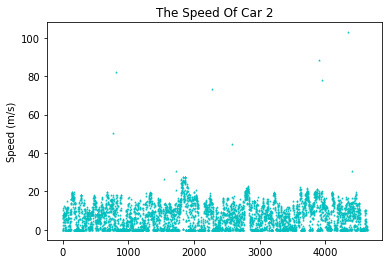

In [7]:
test = pd.read_csv('./20140803/2.csv', index_col=0)
# test.head()
speed = test['speed']

figure,axes=plt.subplots() #得到画板、轴
axes.set_title('The Speed Of Car 2')
# axes.set_xlabel('Number')
axes.set_ylabel('Speed (m/s)')
axes.scatter(range(speed.size), speed, s=1, marker="^", c='c')

In [3]:
# 计算汽车停留时间（即速度为0），并筛选掉停留超过5min的数据点
for j in range(1,13606):
    test = pd.read_csv("D:/Study/车联网资料/寒假作业/Code/20140803/" + str(j) + '.csv', index_col=0)
    test['time'] = pd.to_datetime(test['time'])
    
    # 要删除的点集
    dele = []
    # 每一段中要删除的点集
    tmp = []
    flag = 0
    t1 = 0
    t2 = 0
    for i in range(test.shape[0]-1):
        if test.loc[i, 'speed'] == 0 and flag == 0:
            flag = 1
            # 记下起点
            t1 = i
        if flag == 1:
            tmp.append(i)
        if flag == 1 and test.loc[i, 'speed'] != 0:
            flag = 0
            tmp.remove(i)
            # 停留终点
            t2 = i
            _t = (test.loc[t2, 'time'] - test.loc[t1, 'time']).seconds
            if _t > 5*60:
                dele.append(tmp)
            tmp = []
            
    ###########################################        
    # 停留时间筛选
    for i in range(len(dele)):
        test.drop(dele[i],axis=0,inplace=True)
    # 速度筛选
    test = test[test['speed']<25]
    # 时间间隔筛选
    test = test[test['time_dis']>5]
    test = test[test['time_dis']<65]
    ###########################################
    test.to_csv("D:/Study/车联网资料/寒假作业/Code/20140803/" + str(j) + '.csv', index=False)
    # （以后直接read_csv('xxx.csv')）
    
    if j%100 == 0:
        print(str(j) + " Finished")

100 Finished
200 Finished
300 Finished
400 Finished
500 Finished
600 Finished
700 Finished
800 Finished
900 Finished
1000 Finished
1100 Finished
1200 Finished
1300 Finished
1400 Finished
1500 Finished
1600 Finished
1700 Finished
1800 Finished
1900 Finished
2000 Finished
2100 Finished
2200 Finished
2300 Finished
2400 Finished
2500 Finished
2600 Finished
2700 Finished
2800 Finished
2900 Finished
3000 Finished
3100 Finished
3200 Finished
3300 Finished
3400 Finished
3500 Finished
3600 Finished
3700 Finished
3800 Finished
3900 Finished
4000 Finished
4100 Finished
4200 Finished
4300 Finished
4400 Finished
4500 Finished
4600 Finished
4700 Finished
4800 Finished
4900 Finished
5000 Finished
5100 Finished
5200 Finished
5300 Finished
5400 Finished
5500 Finished
5600 Finished
5700 Finished
5800 Finished
5900 Finished
6000 Finished
6100 Finished
6200 Finished
6300 Finished
6400 Finished
6500 Finished
6600 Finished
6700 Finished
6800 Finished
6900 Finished
7000 Finished
7100 Finished
7200 Finished
7